In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
import math
import scipy.optimize as opt
import random
from functools import partial
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from random import gauss
warnings.filterwarnings("ignore")
import yfinance as yf

# J matrix

In [2]:
def J(eps, sigma, beta):
    n = len(eps)
    theta = np.array([1/(1-beta),0,0])
    J = np.zeros((3,3))
    for i in range(1,len(eps)):
        for j in range(i):
            theta[1] += (beta**i) * (eps[i-j-1]**2)
            theta[2] += (beta**i) * (sigma[i-j-1]**2)
        thetat = np.array([theta]).transpose()
        J+= np.dot(thetat, [theta])/(sigma[i]**2)
        theta[1] = 0
        theta[2] = 0
    return J/n

In [3]:
def built_in_estimation(X):
    model = arch_model(X, p=1, q=1, dist='StudentsT')
    model_fit = model.fit(update_freq=5, disp='off')
    return model_fit.params['omega'], model_fit.params['alpha[1]'], model_fit.params['beta[1]']

In [4]:
def simulate_GARCH(n, omega, alpha, beta=0):
    
    # Initialize our values
    sigma1 = math.sqrt(omega / (1 - alpha - beta))
    X = np.ndarray(n)
    sigma = np.ndarray(n)
    sigma[0] = sigma1
    theta = np.zeros(3)
    theta[0] = 1/(1-beta)
    for t in range(1, n):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(omega + beta * sigma[t - 1]**2 + alpha * X[t - 1]**2)
        
    X[n - 1] = sigma[n - 1] * np.random.normal(0, 1)    
    
    return X, sigma

In [5]:
X, _ = simulate_GARCH(n= 1000, omega = 0.1, alpha = 0.3, beta = 0.1)
X = X[100:]

In [6]:
# Here's function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    w = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = w + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

In [7]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

In [8]:
objective = partial(negative_log_likelihood, X)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print('theta MLE: ' + str(result.x))

theta MLE: [0.06911283 0.32335322 0.2332362 ]


In [9]:
def garch_estimation(X):
    objective = partial(negative_log_likelihood, X)
    cons = ({'type': 'ineq', 'fun': constraint1},
    {'type': 'ineq', 'fun': constraint2},
    {'type': 'ineq', 'fun': constraint3})
    result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
    return   result.x[0], result.x[1], result.x[2]

In [10]:
Data = pd.read_csv('/Users/gosa/Downloads/process.csv')
Data = np.array(Data['x'])
Data = Data[5:]
Data

array([ 3.22327561, -5.5322297 , -0.74746689, ..., -2.66164779,
        1.16506873,  0.62921784])

In [11]:
omega, alpha, beta = garch_estimation(X = Data)

In [12]:
def moments(array):
    mean = sum(array)/len(array)
    var = 0
    for element in array:
        var+= (mean - element)**2
    var = np.sqrt(var)/(len(array)-1)
    return mean, var

In [13]:
print(omega)

1.0386346541198863


### We simulate GARCH processes using a function simulate_GARCH(n, omega, alpha, beta=0) and simular parameters  $\theta = (\omega,\alpha,\beta) $ , then we estimate a set of parameters $\theta = (\omega, \alpha,\beta )$ for each process, using a function garch_estimation(X). 

In [16]:
def simulation_estimation(N ,omega, alpha, beta):
    theta_est = np.zeros((3,N))
    J_est = np.zeros((3,3))
    for i in range(N):
        X, sigmas = simulate_GARCH(n=1000, omega=omega, alpha=alpha, beta=beta)
        omega_est, alpha_est, beta_est = garch_estimation(X = X)
        theta_est[0][i] = omega_est
        theta_est[1][i] = alpha_est
        theta_est[2][i] = beta_est
        J_est += J(X, sigmas, beta_est)
    return theta_est, 2*np.linalg.inv(J_est/N)

In [37]:
theta = [0.1, 0.7, 0.2]
theta_est, Sigma_est = simulation_estimation(N= 100,omega = theta[0], alpha = theta[1], beta = theta[2])

In [38]:
names = ['omega', 'alpha', 'beta']
for i in range(3):
    CI = stats.norm.interval(alpha=0.95, loc= np.mean(theta_est[i]), scale=stats.sem(theta_est[i]))
    print('Confidence Interval for', names[i],  CI, 'True Value of', names[i], 'is', theta[i])

Confidence Interval for omega (0.09837955380859471, 0.10403223944938163) True Value of omega is 0.1
Confidence Interval for alpha (0.6681660517370727, 0.697730072878409) True Value of alpha is 0.7
Confidence Interval for beta (0.1912415678443567, 0.2118108339796121) True Value of beta is 0.2


In [39]:
for i in range(3):
    mean, var = moments(theta_est[i])
    print(mean, var, Sigma_est[i][i])

0.10120589662898814 0.0014493028625974483 0.3462992440233114
0.6829480623077407 0.007579975819080863 61025.58357579133
0.20152620091198428 0.005273793411799268 30089.230501664217


### Boxplots

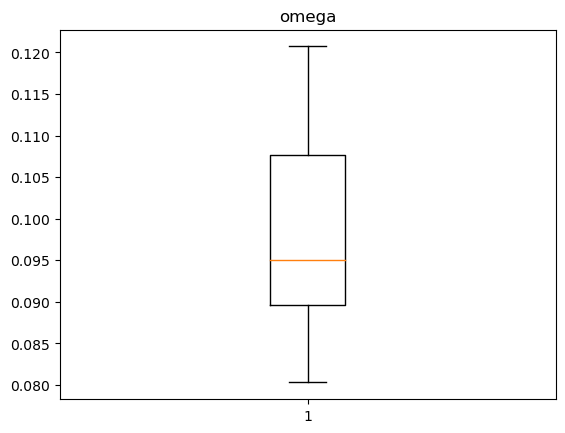

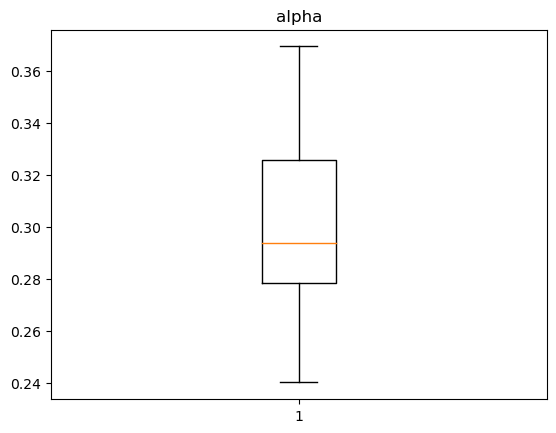

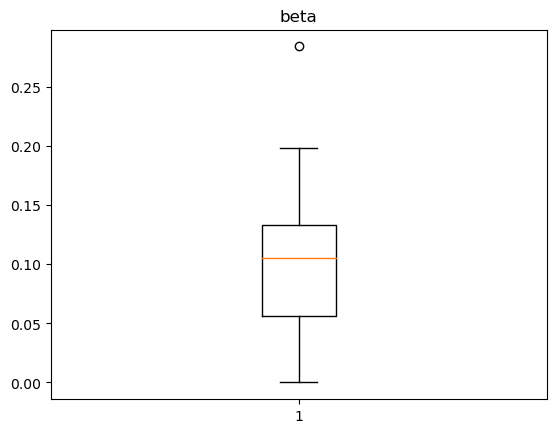

In [20]:
fig1, ax1 = plt.subplots()
ax1.set_title('omega')
ax1.boxplot(theta_est[0])
plt.savefig('omega.png')
fig2, ax2 = plt.subplots()
ax2.set_title('alpha')
ax2.boxplot(theta_est[1])
plt.savefig('alpha.png')
fig3, ax3 = plt.subplots()
ax3.set_title('beta')
ax3.boxplot(theta_est[2])
plt.savefig('beta.png')
plt.show()

### Garch with student distribution

In [198]:
def simulate_student_GARCH(n, omega, alpha, df, beta=0):
    
    # Initialize our values
    w = np.random.standard_t(df=df, size=n)
    eps = np.zeros_like(w)
    sigsq = np.zeros_like(w)

    for i in range(1, n):
        sigsq[i] = omega + alpha*(eps[i-1]**2) + beta*sigsq[i-1]
        eps[i] = w[i] * np.sqrt(sigsq[i])
    
    return eps, sigsq

In [199]:
np.std(np.random.standard_t(df=5, size=1000))

1.2574642764820618

In [200]:
def student_simulation_eatimation(N ,omega, alpha, beta, df):
    theta_est = np.zeros((3,N))
    for i in range(N):
        X, _ = simulate_student_GARCH(n=1000, omega=omega, alpha=alpha, beta=beta, df=df)
        omega_est, alpha_est, beta_est = built_in_estimation(X)
        theta_est[0][i] = omega_est
        theta_est[1][i] = alpha_est
        theta_est[2][i] = beta_est
        
    return theta_est

In [215]:
theta = [0.3, 0.65, 0.3]
theta_est = student_simulation_eatimation(N= 5000, omega = theta[0], 
                                          alpha = theta[1], beta = theta[2], df=5)

/Users/gosa/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gosa/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gosa/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gosa/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for cod

In [216]:
names = ['omega', 'alpha', 'beta']
for i in range(3):
    CI = stats.t.interval(alpha=0.99, df=5,
                             loc= np.mean(theta_est[i]), scale=stats.sem(theta_est[i]))
    print('Confidence Interval for', names[i],  CI, 'True Value of', names[i], 'is', theta[i])
    print(CI[0]< theta[i] and theta[i]< CI[1]) 

Confidence Interval for omega (-18328.827113279476, 37639.199434521746) True Value of omega is 0.3
True
Confidence Interval for alpha (0.6644815704711546, 0.6712359599033382) True Value of alpha is 0.65
False
Confidence Interval for beta (0.32876285885316103, 0.3355174291547376) True Value of beta is 0.3
False


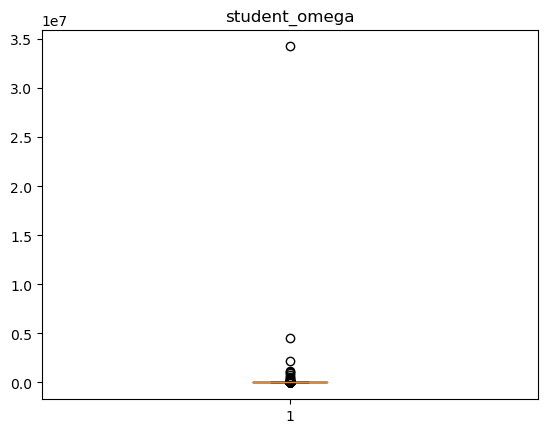

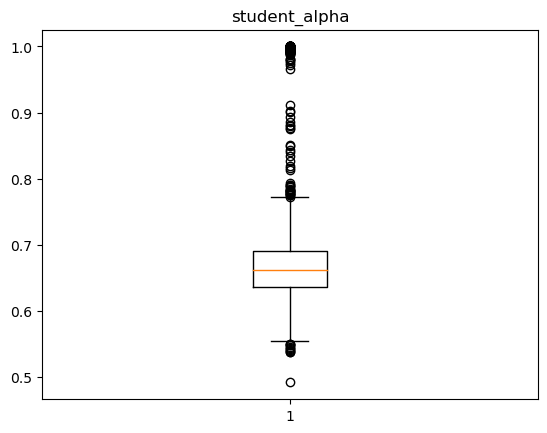

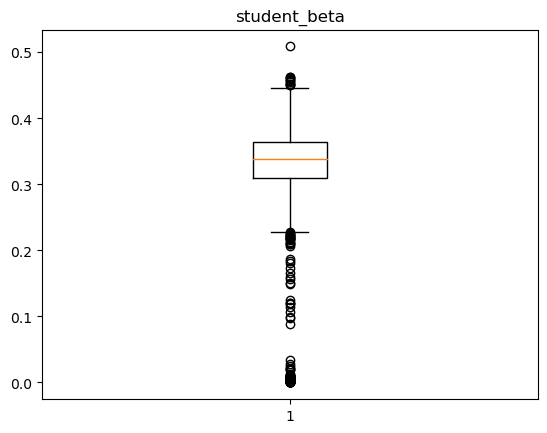

In [225]:
fig1, ax1 = plt.subplots()
ax1.set_title('student_omega')
ax1.boxplot(theta_est[0][100:])
plt.savefig('student_omega.png')
fig2, ax2 = plt.subplots()
ax2.set_title('student_alpha')
ax2.boxplot(theta_est[1])
plt.savefig('student_alpha.png')
fig3, ax3 = plt.subplots()
ax3.set_title('student_beta')
ax3.boxplot(theta_est[2])
plt.savefig('student_beta.png')
plt.show()

In [218]:
print(moments(theta_est[0]),moments(theta_est[1]),moments(theta_est[2]))

(9655.18616062113, 6940.927494184643) (0.6678587651872445, 0.0008376519632371276) (0.33214014400394937, 0.0008376743939251478)


# Bootstrap

In [204]:
eps, sigm = simulate_student_GARCH(n=1000, omega=0.01, alpha=0.3, beta=0.3, df=5)

In [205]:
model = arch_model(eps, p=1, q=1, dist='StudentsT')
model_fit = model.fit(update_freq=5, disp='off')
forecasts = model_fit.forecast(horizon=5, start=995, simulations = 1000, method='bootstrap')

In [206]:
forecast = forecasts.variance.tail()
print(forecast)

          h.1       h.2       h.3       h.4       h.5
995  0.038112  0.046080  0.050767  0.056515  0.060284
996  0.029006  0.040757  0.048788  0.055164  0.063516
997  0.025779  0.038475  0.051128  0.056503  0.057377
998  0.026541  0.038981  0.048959  0.058652  0.058025
999  0.054771  0.060289  0.068862  0.066532  0.075007


In [207]:
eps = pd.DataFrame(eps[995:1000], index=range(995,1000) )
forecast = forecast['h.1']

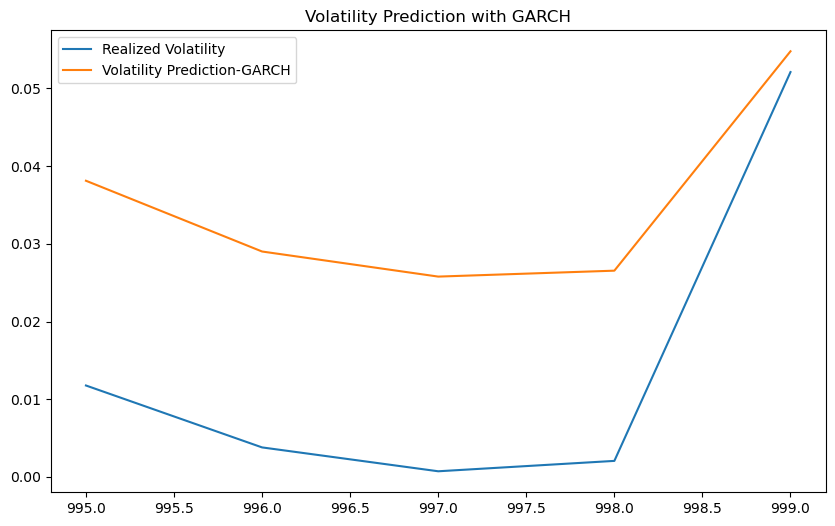

In [208]:
plt.figure(figsize=(10, 6))
plt.plot(eps**2, label='Realized Volatility') 
plt.plot(forecast, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12) 
plt.legend()
plt.show()

In [219]:
eps

,0
995,-0.108475
996,0.061640
997,0.026991
998,-0.045445
999,-0.228247


# get a sample of $\eta$

In [220]:
eps, sigm = simulate_GARCH(n=1000, omega=0.01, alpha=0.3, beta=0.3)

In [232]:
etas = []
for i in range(1000):
    etas.append(eps[i]/sigm[i])
print(len(etas))

1000


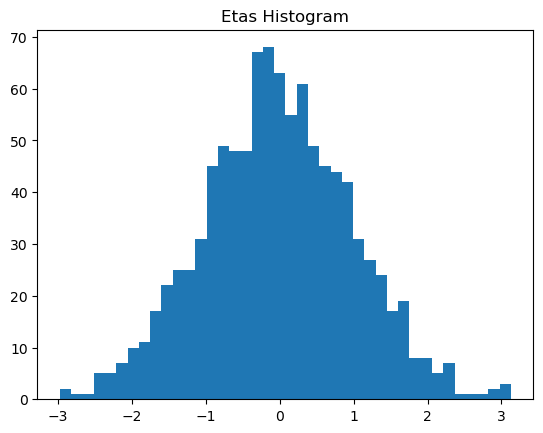

In [237]:
plt.hist(etas, bins=40)
plt.title('Etas Histogram', fontsize=12) 
plt.show()